# Analysis of Customer Reviews

**Notes:**

Sections to analyze 
- overall, feedback, cons

The goal is to try and pull out similar phrases or common value propositions to find trends of they key reasons customers buy and also what they may dislike (the cons)


In [1]:
# load libraries
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from matplotlib import pyplot as plt
import seaborn as sns

from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from PIL import Image
import collections
from collections import Counter


In [2]:
# create a list of stop words (filler words)
# nltk.download('stopwords')
stopWords = set(stopwords.words('english'))

# Load in the data

In [3]:
# read in data from the excel file
raw_data = pd.read_excel("review_data2.xlsx", sheet_name='Bonusly')

# check dimensions and format
print(raw_data.shape)
raw_data.head(3)

(1104, 13)


Name              Title  \
0   Jared M.        NOC Manager   
1    John G.      CTO & Founder   
2  Yasser F.  VP of Engineering   

                             Industry/Employee Count Overall Rating  \
0  Information Technology and Services, 11-50 emp...     2020-05-05   
1  Information Technology and Services, 11-50 emp...     2020-05-05   
2  Information Technology and Services, 51-200 em...     2020-04-05   

  ReviewSource__HalfUnitMarginDiv-lnjke6-1 2  \
0                           Source: Capterra   
1                           Source: Capterra   
2                           Source: Capterra   

                                        Review Title  \
0  “Zero Admin Overhead Employee Recogntion Platf...   
1                 “Peer Recognition...on Autopilot ”   
2                       “A must have in any company”   

                                             Overall  \
0  Feed the tool money and watch your employees g...   
1                                             Great!   
2  Bonusly accomplishes what I need which is real...   

                                            Feedback  \
0  Ease of Use: Bonusly is the pinnacle of set it...   
1  Can't say enough good things about Bonus.ly. T...   
2  - Easy to set up and use\n - Slack integration...   

                                                Cons  \
0  Bonusly could probably do to work on some addi...   
1  That we didn't implement it sooner at our orga...   
2  - Weak rewards dashboard\n - Manual fulfillmen...   

  StarRating__Rating-sc-9jwzgg-1 4 RatingContainer__Root-zgij78-0 5  \
0                              NaT                              NaN   
1                       2020-05-05                  Value for Money   
2                       2020-04-05                  Value for Money   

  StarRating__Rating-sc-9jwzgg-1 5 RatingContainer__Root-zgij78-0 6  
0                              NaT                              NaN  
1                       2020-05-05          Likelihood to Recommend  
2                       2020-05-05          Likelihood to Recommend

In [4]:
# raw_data.info()

In [5]:
# raw_data['Industry'].unique()

The Overall Rating and Likelihood to Recommend were read in as dates, so I'll have to fix that.

## Data Cleaning

In [6]:
def format_text(column, company_name):
    # drop punctuation and make everything lowercase
    column = column.str.replace('[^\w\s]','').str.lower()
    
    # remove company name since it shows up in all cases
    column = column.str.replace(company_name.lower(), '')
#     column = column.str.replace('nan', '')
    
    return column.astype(str)


# function to clean up the text data
def clean_data(data, company_name, cols_to_keep = []):
    
    # to prevent overwriting the original data
    data = data.copy()
    
    # get actual overall rating value instead of a date
    data['Rating_'] = data['Overall Rating'].dt.month
    
    # covert all text to lowercase, and drop punctuation
    data['Overall_'] = format_text(data['Overall'], company_name=company_name)
    data['Overall_'] = np.where(data['Overall_'] == 'nan', '', data['Overall_'])

    data['Feedback_'] = format_text(data['Feedback'], company_name=company_name)
    data['Feedback_'] = np.where(data['Feedback_'] == 'nan', '', data['Feedback_'])
    
    
    data['Cons_'] = format_text(data['Cons'], company_name=company_name)
    data['Cons_'] = np.where(data['Cons_'] == 'nan', '', data['Cons_'])
    
    data['Combined_'] = data['Overall_'] + " " + data['Feedback_'] + " " + data['Cons_']
    
    # polarity of the review (score between -1 and 1)
    data['Polarity_Overall'] = data['Overall_'].map(lambda text: TextBlob(text).sentiment.polarity)
    data['Polarity_Feedback'] = data['Feedback_'].map(lambda text: TextBlob(text).sentiment.polarity)
    data['Polarity_Cons'] = data['Cons_'].map(lambda text: TextBlob(text).sentiment.polarity)
    
    # the length of the overall review (the raw, unformatted reviews)
    data['review_len'] = data['Overall'].astype(str).apply(len)
    data['word_count_Overall'] = data['Overall'].apply(lambda x: len(str(x).split()))   
    data['word_count_Feedback'] = data['Feedback'].apply(lambda x: len(str(x).split()))    
    data['word_count_Cons'] = data['Cons'].apply(lambda x: len(str(x).split()))    

    
    if len(cols_to_keep) != 0:
        # only return the columns of interest
        data = data[cols_to_keep]
        
    
    return data

In [7]:
df = clean_data(raw_data, company_name="Bonusly")
df.head(3)

Name              Title  \
0   Jared M.        NOC Manager   
1    John G.      CTO & Founder   
2  Yasser F.  VP of Engineering   

                             Industry/Employee Count Overall Rating  \
0  Information Technology and Services, 11-50 emp...     2020-05-05   
1  Information Technology and Services, 11-50 emp...     2020-05-05   
2  Information Technology and Services, 51-200 em...     2020-04-05   

  ReviewSource__HalfUnitMarginDiv-lnjke6-1 2  \
0                           Source: Capterra   
1                           Source: Capterra   
2                           Source: Capterra   

                                        Review Title  \
0  “Zero Admin Overhead Employee Recogntion Platf...   
1                 “Peer Recognition...on Autopilot ”   
2                       “A must have in any company”   

                                             Overall  \
0  Feed the tool money and watch your employees g...   
1                                             Great!   
2  Bonusly accomplishes what I need which is real...   

                                            Feedback  \
0  Ease of Use: Bonusly is the pinnacle of set it...   
1  Can't say enough good things about Bonus.ly. T...   
2  - Easy to set up and use\n - Slack integration...   

                                                Cons  \
0  Bonusly could probably do to work on some addi...   
1  That we didn't implement it sooner at our orga...   
2  - Weak rewards dashboard\n - Manual fulfillmen...   

  StarRating__Rating-sc-9jwzgg-1 4  ...  \
0                              NaT  ...   
1                       2020-05-05  ...   
2                       2020-04-05  ...   

                                           Feedback_  \
0  ease of use  is the pinnacle of set it and for...   
1  cant say enough good things about  their aweso...   
2   easy to set up and use\n  slack integration\n...   

                                               Cons_  \
0   could probably do to work on some additional ...   
1  that we didnt implement it sooner at our organ...   
2   weak rewards dashboard\n  manual fulfillment ...   

                                           Combined_  Polarity_Overall  \
0  feed the tool money and watch your employees g...          0.000000   
1  great cant say enough good things about  their...          0.800000   
2   accomplishes what i need which is realtime pe...          0.149583   

  Polarity_Feedback Polarity_Cons review_len word_count_Overall  \
0          0.234091       0.31875        205                 35   
1          0.224934       0.00000          6                  1   
2          0.433333      -0.37500        536                 89   

   word_count_Feedback  word_count_Cons  
0                   65               29  
1                  184                9  
2                   32               10  

[3 rows x 25 columns]

### A vast majority of the reviews are positive

In [8]:
# how many of each rating?
df['Rating_'].value_counts()

5    905
4    179
3     19
2      1
Name: Rating_, dtype: int64

In [9]:
# how many of each rating as a percent?
df['Rating_'].value_counts() * 100/ df.shape[0]

5    81.974638
4    16.213768
3     1.721014
2     0.090580
Name: Rating_, dtype: float64

## Looking at Review with Highest and Lowest Polarities

Looking at all of the reviews by hand would be quite tedious. Instead we can rank the reviews based on their sentiment, and then glance at the most polarized reviews. This will help to hone in on the biggest likes/disklikes of customers. 

I also added a filter to only include reviews that have a minimum word count (specified in the code). That way we are seeing reviews with more detail instead of reviews with only hype (e.g. "I love this!!!")

(Note that the sentiment polarity of a review is scored between -1 (negative sentiment) and 1 (positive sentiment)



#### Overall

In [10]:
# function to look at most polar reviews
def view_most_polar_reviews(data, field, positive=True, n=7, min_words = 20):
    """
    This function grabs the most polar reviews (positive by default)
    To see negateive reviews change positive=False
    """
    order = not positive
    temp_df = data.loc[
    (data['word_count_'+field] >= min_words),
    ['Polarity_'+field,field]
    ].sort_values(by='Polarity_'+field, ascending=order).head(n)
    for row in range(temp_df.shape[0]):
        print("Polarity:",temp_df.iloc[row,0])
        print(temp_df.iloc[row,1])
        print('\n')
    return
    

In [11]:
# most positive
view_most_polar_reviews(df, 'Overall', positive = True, n=7, min_words=20)

Polarity: 1.0
Ease of use and intergration with Slack. Our team loves to Bonusly out for a bday, anniversary, or someone excecuting excellently at our clients.


Polarity: 0.9
Bonusly is incredible for team building and morale. I think every company should offer bonusly. If you're a company that believes in a tool like bonusly, you are immediately saying "I care about my employees well being."


Polarity: 0.85
Good way to recognize others. Still figuring out how to use it best after ~2 months and manage points efficiently.


Polarity: 0.8
This application is a great way to recognize your peers within your company. Definitely a great addition to our company :)


Polarity: 0.8
Bonusly lets me go beyond thank you. It allows me to reward those who help our office run well and those who keep our customers happy.


Polarity: 0.8
I like using the rewards to purchase what I want and you have a great selection of gifts and donations.


Polarity: 0.8
I would recommend using bonusly as it is a gr

In [12]:
# most negative
view_most_polar_reviews(df, 'Overall', positive = False, n=7, min_words=20)

Polarity: -0.2916666666666667
I have been an ardent fan of this software and have implemented in my group to track productivity and reward hard work.


Polarity: -0.25
This tool helps motivate people to interact and brings the shy people out of their shell, which helps with overall office collaboration.


Polarity: -0.2333333333333333
I have already recommended this software to a few organisations. All the benefits are already mentioned in the pros I listed earlier, so this is a useless question


Polarity: -0.2
I like all the features that I can review all my claimed rewards and have the option also to refund a reward that's not available or made by mistake


Polarity: -0.19999999999999998
-Ease of use
 
 -Web or mobile or slack options for giving bonusly
 
 -Number of rewards is crazy and very flexible


Polarity: -0.19791666666666666
The benefit is that the price point for the amount of users we have has been less expensive than other options of the same style.


Polarity: -0.1875
a

#### Feedback

In [13]:
# most positive
view_most_polar_reviews(df, 'Feedback', positive = True, n=7, min_words=20)

Polarity: 1.0
After almost two months of use, I have not found anything that I dislike about the software. The user experience is excellent.


Polarity: 1.0
This drives team bonding I think and comradery. We use it all the time at InVision when someone does something awesome


Polarity: 0.9099999999999999
- very good software to recognize and credit your colleagues and power users at work
 - helps in showing the appreciation for the help received
 - Ease to use
 - plenty of gift options to redeem


Polarity: 0.8
I do not see a con to this function, it is great to be recognized for the work you do day in and day out


Polarity: 0.8
I dont have any cons. I dont think there is anything that we dont like about the system. Everything has been great.


Polarity: 0.8
Whether you use the app, online, or browser extension.....it could not any easier! It's a great way to show appreciation.


Polarity: 0.8
I like that all employees get a say in who can get a bonus. It is a great way to help show 

In [14]:
# most negative
view_most_polar_reviews(df, 'Feedback', positive = False, n=7, min_words=20)

Polarity: -0.6
The restriction of gifs to include used to be abled to be customized, but have since been restricted to a pre-set pool. Disappointing.


Polarity: -0.5
- Sometimes it becomes difficult to find the page where I can see the bonuses given / received for the month


Polarity: -0.4
The admin dashboard is not great. Searching for users to edit, or delete them is a pain when you have 600+ employees (and growing).


Polarity: -0.4
- Retrospectively adding an emoji in the text is a bit annoying 
 - When someone gives a working group a reward and people add on to that the initial giver is not included although they could have been part of the project as well


Polarity: -0.4
Expiration of Bonusly points. If I am out of the office for an extended period of time and not working as closely with my co-workers I hate that I can not retain my allotted monthly points for future use.


Polarity: -0.4
Not a fan of the forced hashtag, it feels cheesy. Update the reward catalog and alert use

#### Cons

In [15]:
# most positive
view_most_polar_reviews(df, 'Cons', positive = True, n=7, min_words=20)

Polarity: 1.0
This is petty...but GIFs take a lot of time to load and sometimes they don't at all. User error? How best to use?


Polarity: 0.8
I wish there was a way to cash out your bonus monetarily. I think also there should be a feature to win additional bonusly when you are awarded team leader in a category


Polarity: 0.8
None that I can think of but it would be great if the rewards could include websites like Nykaa and Myntra.


Polarity: 0.8
The formatting of text in the Bonus.ly website sometimes does not sync as great with the Slack app as we'd like.


Polarity: 0.6
Honestly, I don't know what to tell, hmm maybe some chrome extensions doesn't work here that will make the GIF button won't work


Polarity: 0.6
How I'm restricted from adding my own custom hashtags and that I'm enforced to use a hashtag every time. How my bonusly points don't get carried over, I forgot to give anyone any one month and a lot of people missed out.


Polarity: 0.6
I wish I had all the money in the w

In [16]:
# most negative
view_most_polar_reviews(df, 'Cons', positive = False, n=7, min_words=20)

Polarity: -0.5
I would suggest to add Notes space to custom rewards so employees can mention for example what day they are requesting for time off. Sometimes it gets difficult to track.


Polarity: -0.5
I've purchased rewards and they have been unavailable but I was unable to find this until after I've purchased them.


Polarity: -0.35
Would like ability to post a prop that is anonymous. Sometimes its not good to let everyone know you are thanking someone


Polarity: -0.30000000000000004
That I am being forced to provide a comment in this section and I have no comments about the software


Polarity: -0.30000000000000004
Sometimes the features are slow to loud or difficult to find when updates occur. Also when there are duplicate names it can be difficult to figure out who is who for newcomers.


Polarity: -0.3
Integration with Slack could use some work - the usernames in Slack don't match Bonusly names which can be confusing.


Polarity: -0.3
I don't have any "cons" to share. We haven'

### Grabbing the most common words

In [17]:
def plot_most_common(field, n=15):
    all_words = " ".join(list(df[field])).lower().split()
    all_words = [word for word in all_words if word not in stopWords]

    word_counts_overall = Counter(all_words)
    word_counts_overall.most_common(n)

    word, count = zip(*word_counts_overall.most_common(n))
    plt.figure(figsize=(15,4))
    plt.title(f"Top {n} Most Common Words for {field}")
    plt.bar(word,count)
    plt.xticks(rotation = 90, fontsize = 13)
    plt.show()
    return

#### Overall

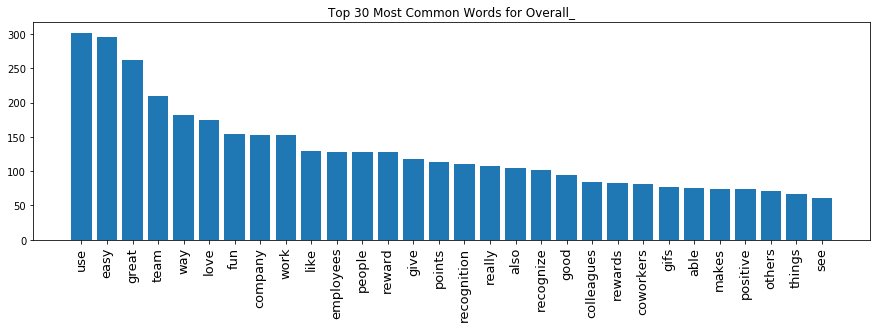

In [18]:
plot_most_common('Overall_', n=30)

#### Feedback

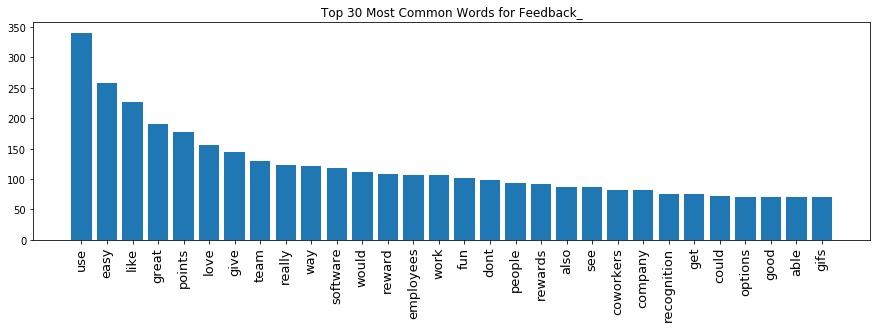

In [19]:
plot_most_common('Feedback_', n=30)

#### Cons

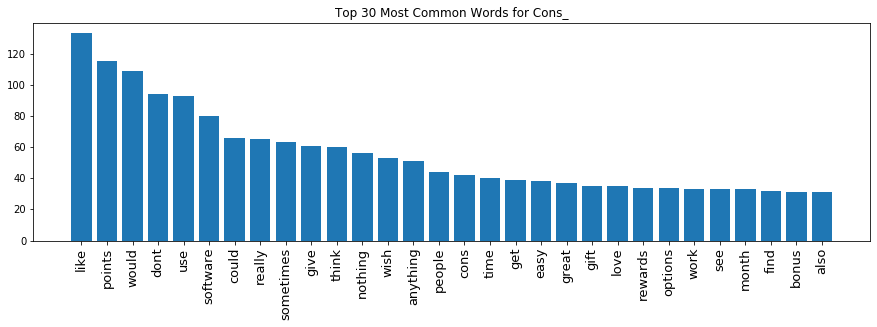

In [20]:
plot_most_common('Cons_', n=30)

## Using Word Charts to get a feel for the relative frequency of each word from the reviews


In [21]:
# function to make a word diagram for each of the columns
def make_word_diagram(text_field):
    text = " ".join(row for row in text_field)
    
    print(f"Total Words: {len(text)}")
    
    # Generate a word cloud image
    wordcloud = WordCloud(stopwords=stopWords, background_color="white").generate(text)
    
    # Display the generated image:
    plt.figure(figsize=[30,15])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
    return  

### Word chart for all text from Overall, Feedback, and Cons

(1104, 25)
Total Words: 351478


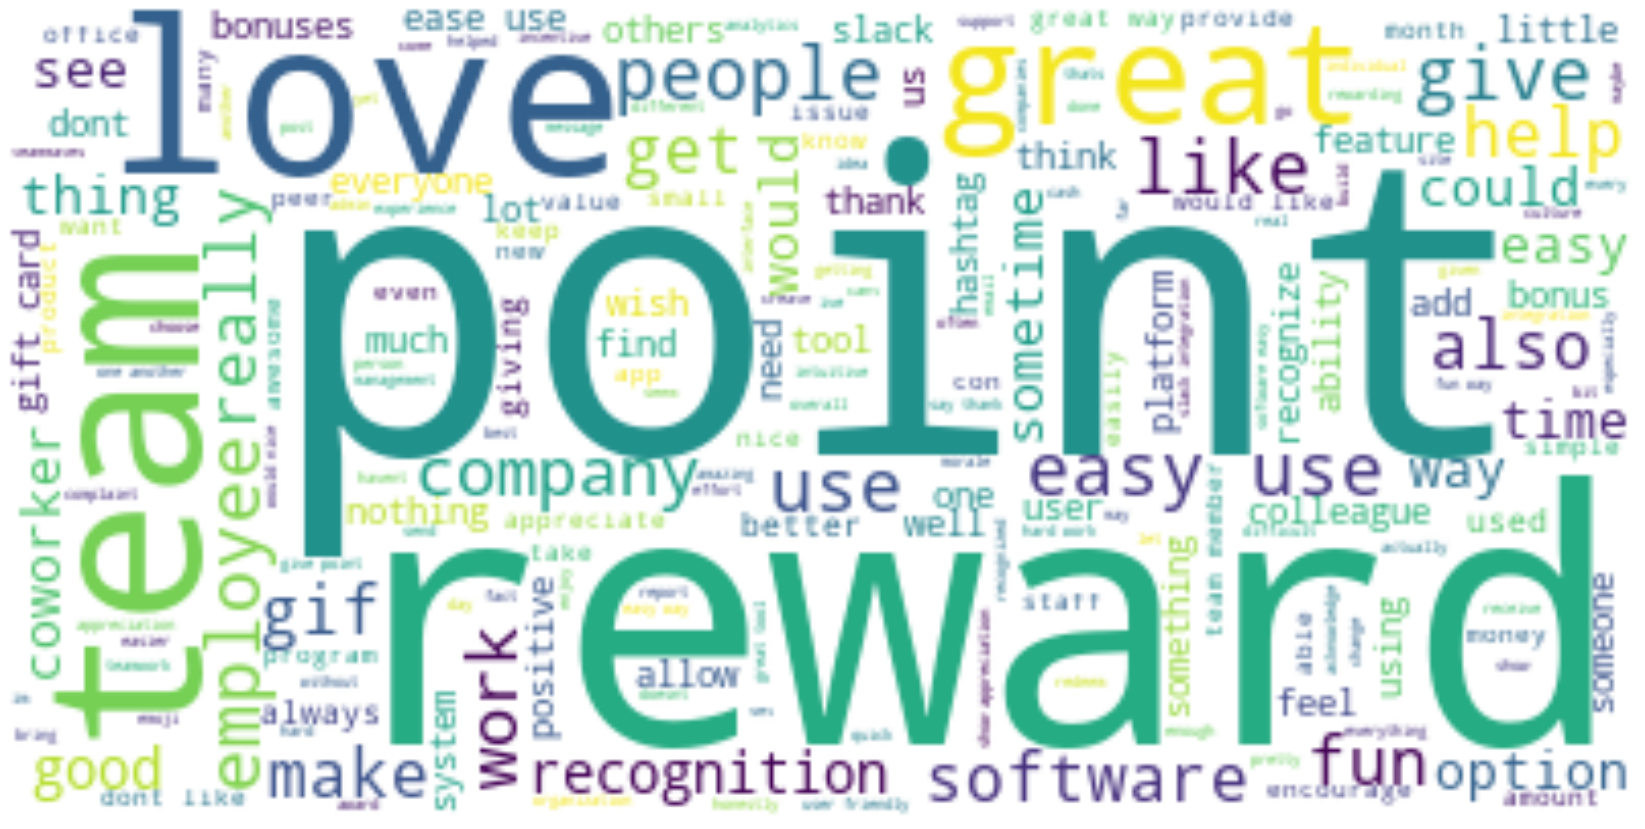

In [22]:
# combined 
temp_df = df#[]

print(temp_df.shape)
make_word_diagram(temp_df['Combined_'])

### Word chart for all text from Overall

(1104, 25)
Total Words: 134379


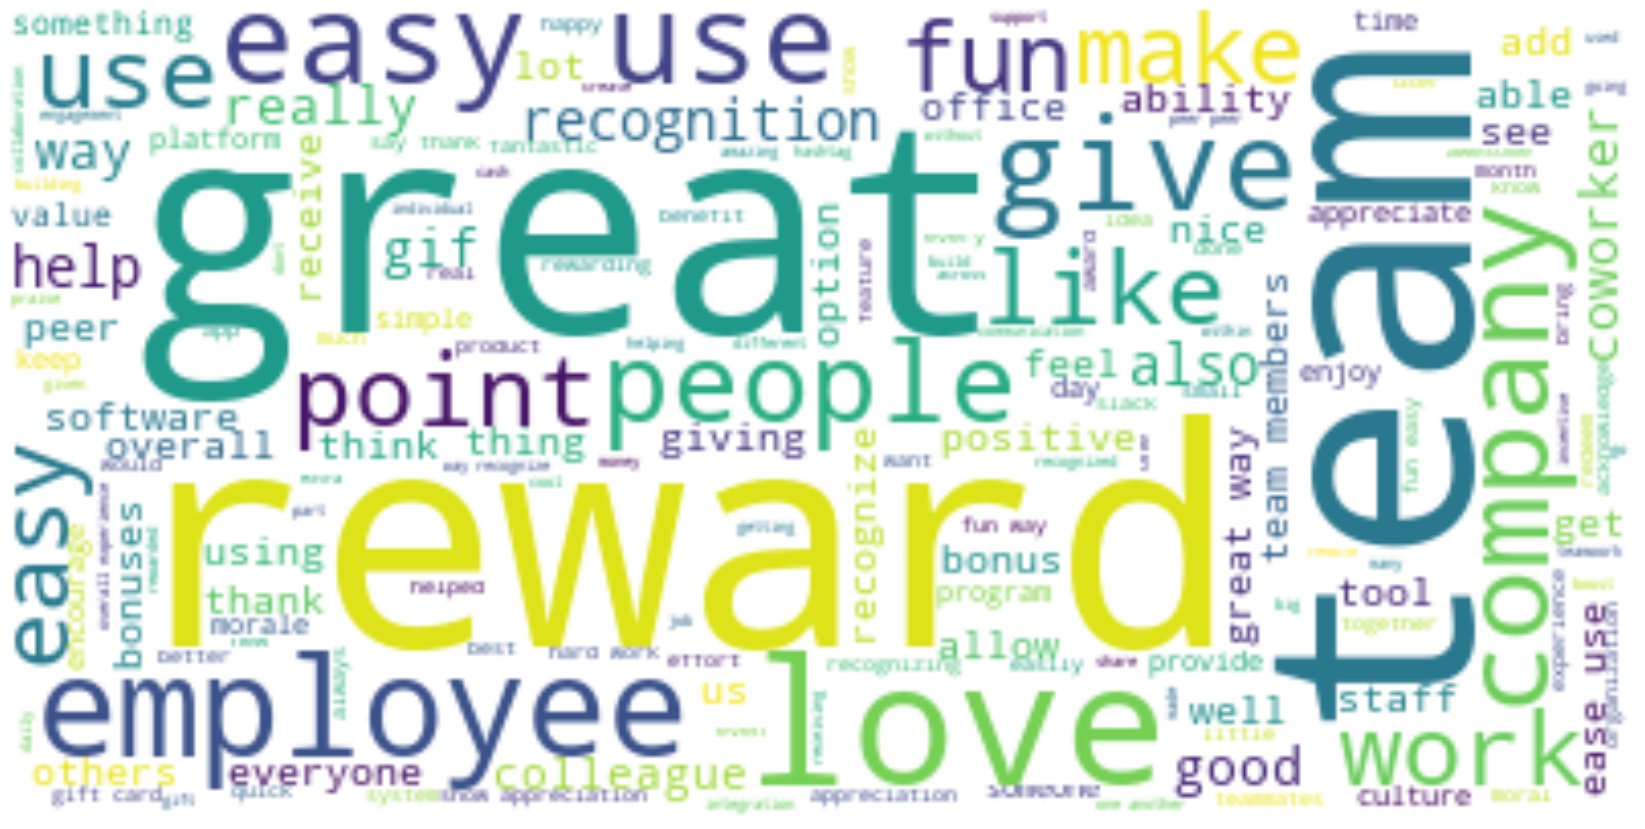

In [23]:
# add a filter based on overall rating
temp_df = df#[]

print(temp_df.shape)
make_word_diagram(temp_df['Overall_'])

### Word chart for all text from Feedback

(1104, 25)
Total Words: 145895


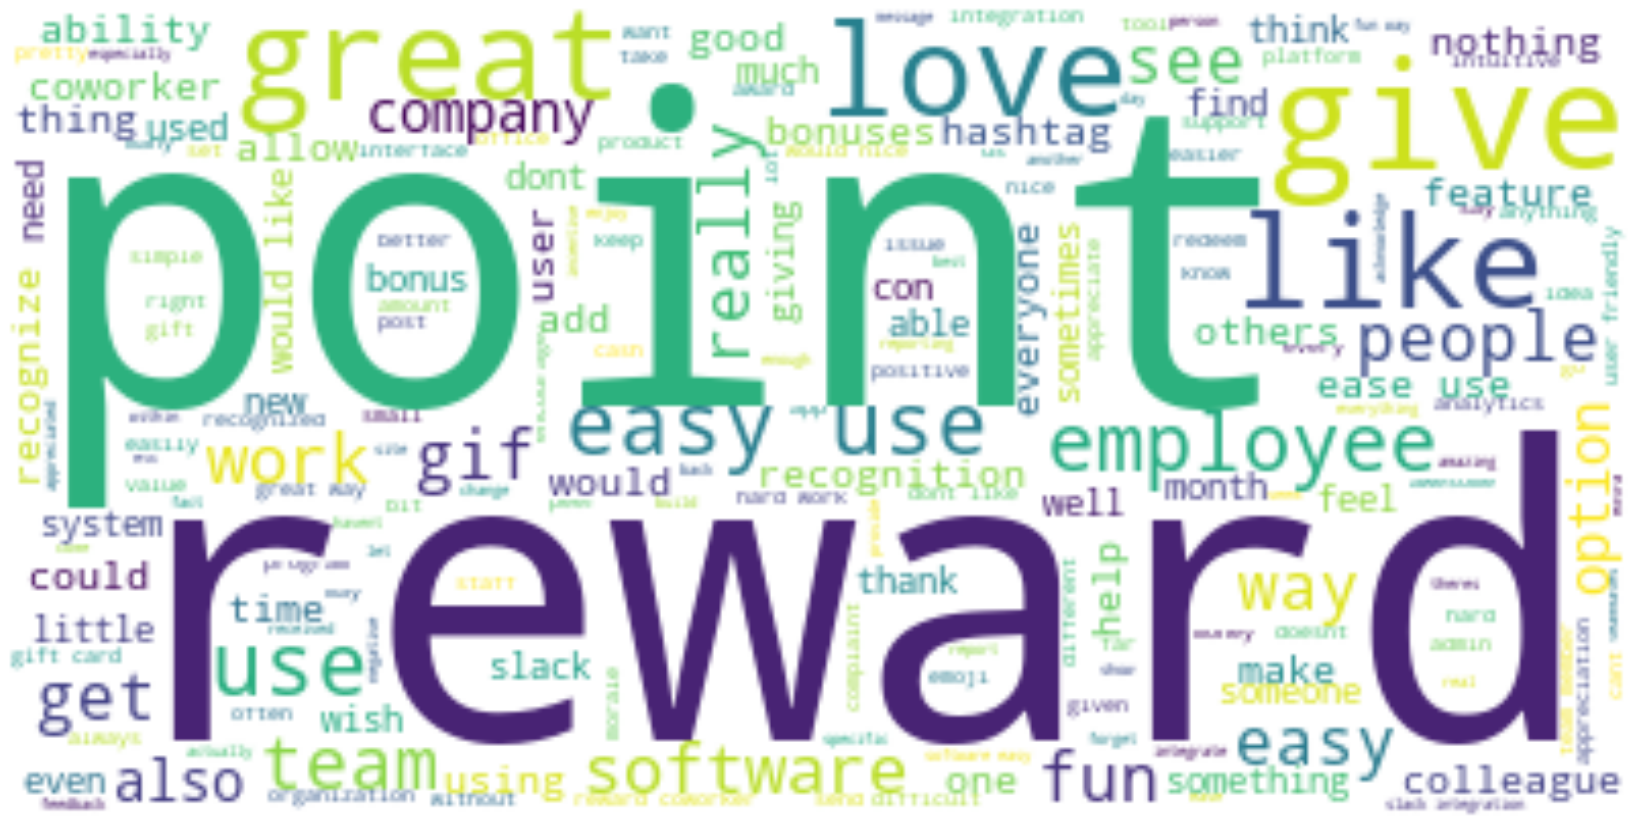

In [24]:
temp_df = df[
    (df['Feedback_'] != 'nan')
]
print(temp_df.shape)
make_word_diagram(temp_df['Feedback_'])

### Word chart for all text from Cons

(1104, 25)
Total Words: 71202


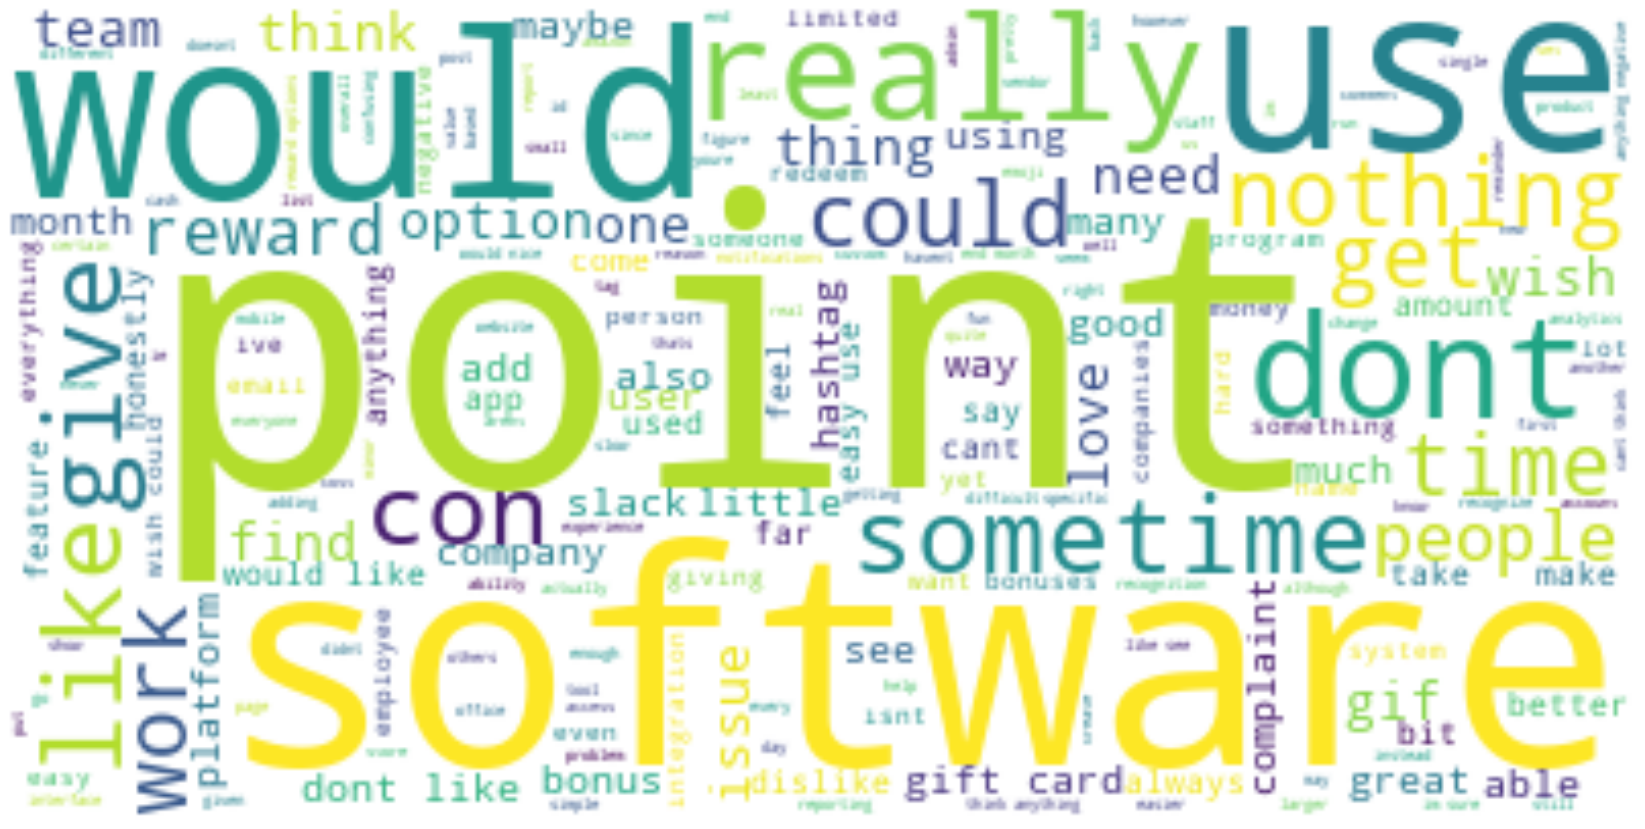

In [25]:
temp_df = df#[]

print(temp_df.shape)
make_word_diagram(df['Cons_'])

Total Words: 15327


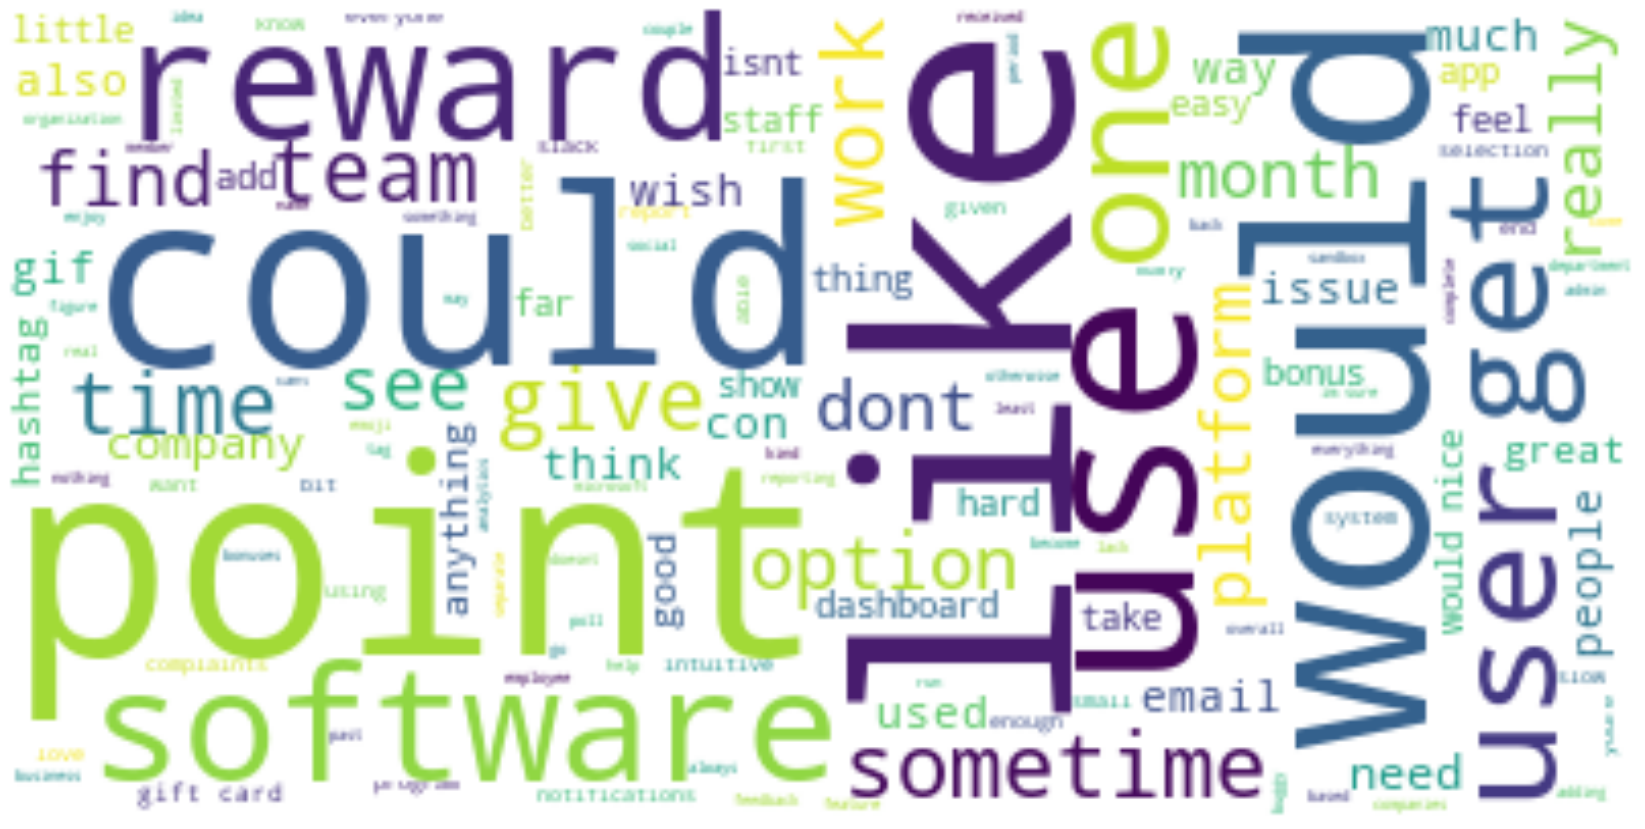

In [26]:
# focus in on non 5 star reviews
temp_df = df[
    (df['Rating_'] != 5)
]
make_word_diagram(temp_df['Cons_'])

### Scatter Plots of Polarity, Ratings, and Review Length

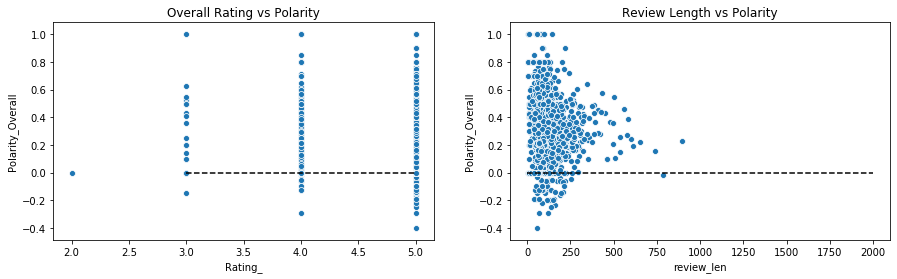

In [27]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.scatterplot(x = 'Rating_', y = 'Polarity_Overall', data = df)
plt.title("Overall Rating vs Polarity")
plt.hlines(y=0, xmin=3, xmax=5, linestyles='--')

plt.subplot(1,2,2)
sns.scatterplot(x = 'review_len', y = 'Polarity_Overall', data = df)
plt.title("Review Length vs Polarity")
plt.hlines(y=0, xmin=0, xmax=2000, linestyles='--')
plt.show()

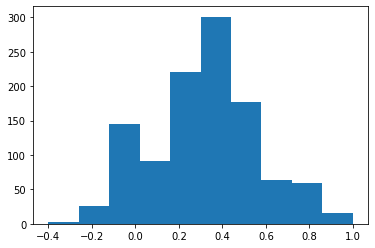

In [28]:
# distribution of overall polarity
plt.hist(df['Polarity_Overall'])
plt.show()

### End of Notebook